# Прогнозирование уровня средней заработной платы в России

Как и было оговорено в задании, выполняем исследование по шагам.

### Шаг 1. Загрузка и визуализация данных
Загружаем дополненный свежими данными (февраль 2020) ВШЭ временной ряд и визуализируем его.
Очевиден повышательный тренд, а также сезонность, судя по данным и графику,
резкий всплеск средние зарплаты испытывают перед каждым началом года (13-я зарплата, бонусы), промежуточный - в середине года. Так же заметно, что с ростом тренда волатильность (дисперсия) показателя также заметно увеличивается.

Populating the interactive namespace from numpy and matplotlib


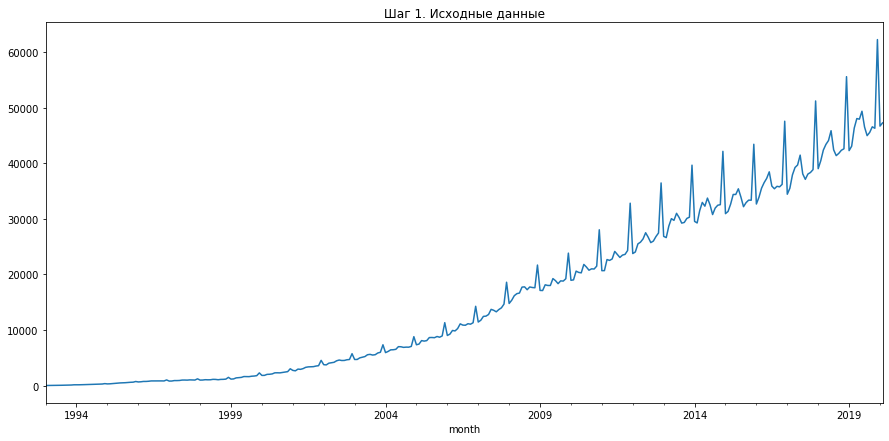

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from scipy import stats
import statsmodels.api as sm

df = pd.read_csv("WAG_C_M.csv", ';', index_col='month', parse_dates=['month'], dayfirst=True)
df = df.rename(columns = {'WAG_C_M':'wage'})

plt.figure(figsize(15,7))
df['wage'].plot(kind='line', title="Шаг 1. Исходные данные")

### Шаг 2. Cтабилизация дисперсии
Стабилизируем дисперсию преобразованием Бокса-Кокса, для чего выясним оптимальный коэффициент при помощи метода stats.boxcox

Оптимальный коэффициент: 0.289440


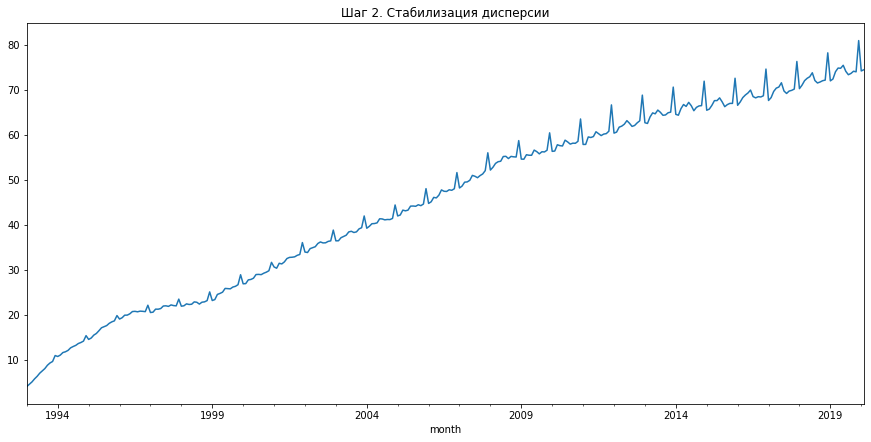

In [2]:
import math

#Преобразование Бокса-Кокса
def boxcox(x, _lambda):
    return (x**_lambda - 1)/_lambda

#Обратное преобразование Бокса-Кокса
def invboxcox(y, lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

_lambda = stats.boxcox(df['wage'])[1]

df['wage2'] = df['wage'].map(lambda x: boxcox(x, _lambda))
print("Оптимальный коэффициент: %f" % _lambda)

plt.figure(figsize(15,7))
df['wage2'].plot(kind='line', title="Шаг 2. Стабилизация дисперсии")

### Шаг 3. Выбор порядка дифференцирования
Используя критерий Дики-Фуллера, по аналогии с заданием в тестах этой недели, ищем стационарный вид ряда.

In [3]:
#Критерий Дики-Фуллера
def diki_fuller(seq):
    seq = seq[np.isfinite(seq)]
    return sm.tsa.stattools.adfuller(seq)[1]

#Посчитаем критерий для исходного ряда и продифференцированного
difu0 = diki_fuller(df['wage2'])
#Дифференцируем по ближайшим
difu1 = diki_fuller(df['wage2'] - df['wage2'].shift(1))
#Дифференцируем по сезонности
szned = df['wage2'] - df['wage2'].shift(12)
difu12 = diki_fuller(szned)
#Комбинируем два подхода выше, как в тесте
difu1_12 = diki_fuller(szned - szned.shift(1))

difu0, difu1, difu12, difu1_12

(0.7918389728546724,
 0.0061625312404443786,
 0.11932233664223257,
 2.7019923201587295e-10)

Наименьшее значение по критерию Дики-Фуллера ряд средних российских зарплат выдает при комбинировании сезонного и однократного дифференцирования, как и в тестовом примере про удои молока.

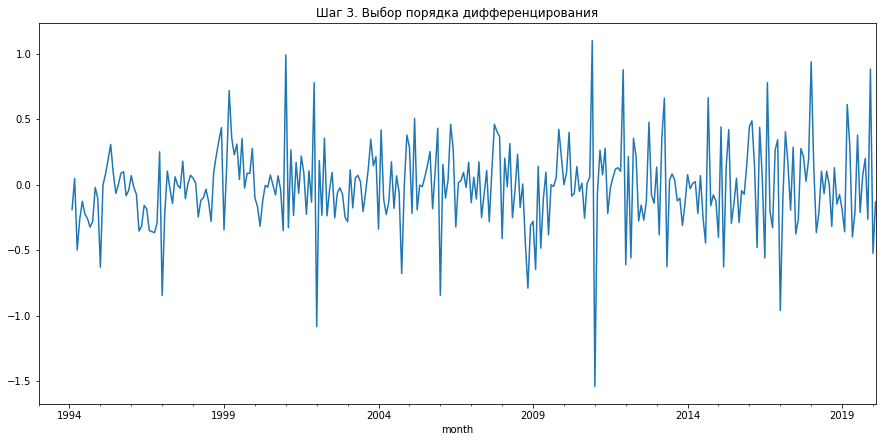

In [4]:
df['wage3'] = szned - szned.shift(1)
df['wage3'].plot(kind='line', title="Шаг 3. Выбор порядка дифференцирования")

### Шаг 4. Выбор начальных приближений для p, q, P, Q
Построим автокорреляционную функцию и частичную автокорреляционную функцию для определения начальных приближений.


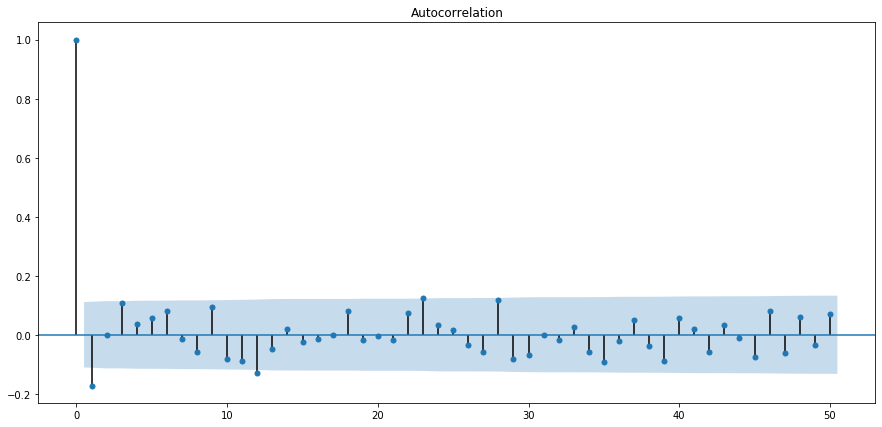

<Figure size 1080x504 with 0 Axes>

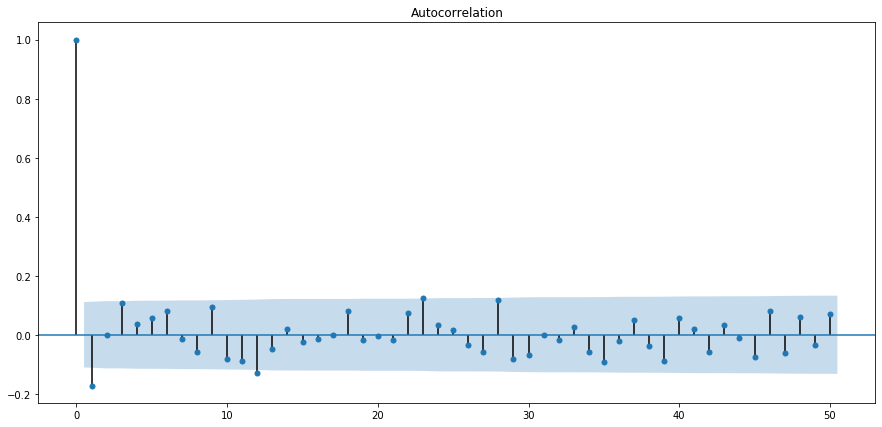

In [5]:
series = df['wage3']
series = series[np.isfinite(series)]

plt.figure(figsize(15,7))
sm.graphics.tsa.plot_acf(series.squeeze(), lags=50)


Из автокорреляционной функции выводим Q = 0 (последний значимый лаг, кратный 12), q = 1 (последний значимый несезонный лаг)

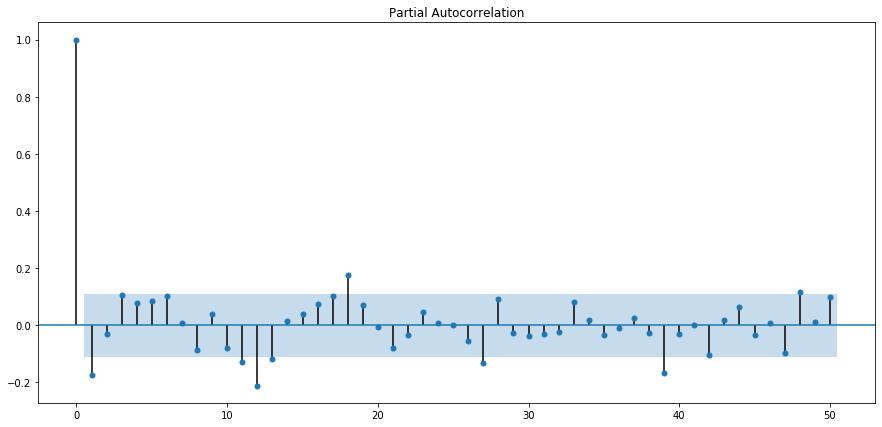

<Figure size 1080x504 with 0 Axes>

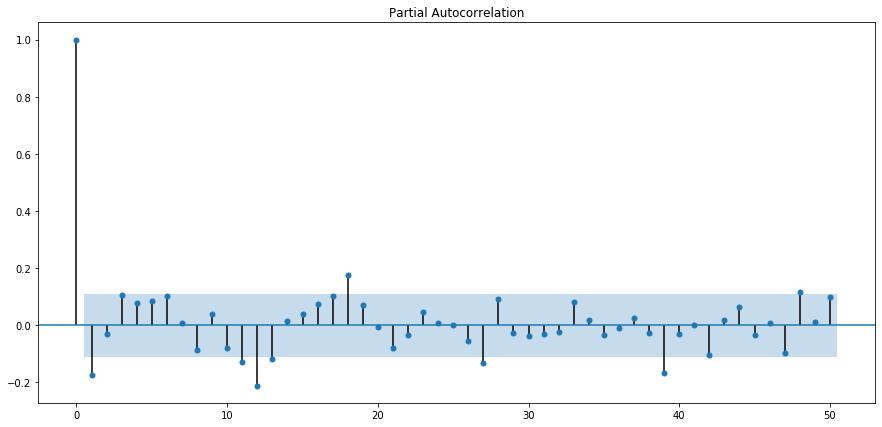

In [6]:
plt.figure(figsize(15,7))
sm.graphics.tsa.plot_pacf(series.squeeze(), lags=50)

Из частичной автокорреляционной функции выводим P = 1 (значимый сезонный лаг, кратный 12), в качестве p выбираем значение 3.

### Шаг 5. Обучение и сравнение моделей-кандидатов, выбор победителя.
Поступаем строго как в ноутбуке для ознакомления.


In [7]:
from itertools import product
import warnings

#Начальные приближения
ps = range(0, 4)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [8]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df['wage2'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 5.14 s


In [9]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
15  (3, 1, 1, 0)  154.801858
13  (3, 0, 1, 0)  159.160673
3   (0, 1, 1, 0)  160.346554
5   (1, 0, 1, 0)  160.388162
9   (2, 0, 1, 0)  161.589156


Таким образом лучшая модель имеет параметры (3, 1) X (1, 0), что соответствует начальным приближениям.

In [10]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              wage2   No. Observations:                  326
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -71.401
Date:                            Thu, 07 May 2020   AIC                            154.802
Time:                                    11:46:17   BIC                            177.279
Sample:                                01-01-1993   HQIC                           163.784
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4464      0.206      2.167      0.030       0.043       0.850
ar.L2          0.1197      0.074   

### Шаг 6. Анализ остатков построенной модели
Считаем и выводим остатки лучшей модели

Критерий Стьюдента: p=0.392453
Критерий Дики-Фуллера: p=0.000000


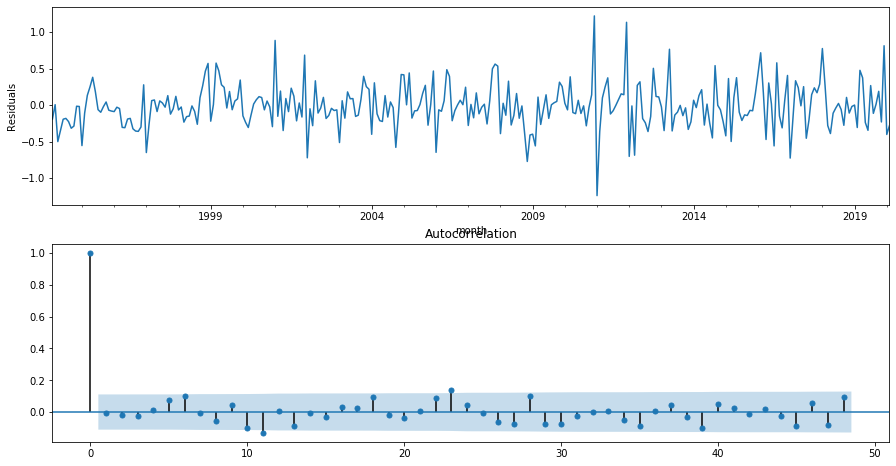

In [11]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Как видим, по критерию Дики-Фуллера остатки стационарны, а по критерию Стьюдента они несмещенные, таким образом модификации модели не требуется. Посмотрим, насколько хорошо модель описывает данные.


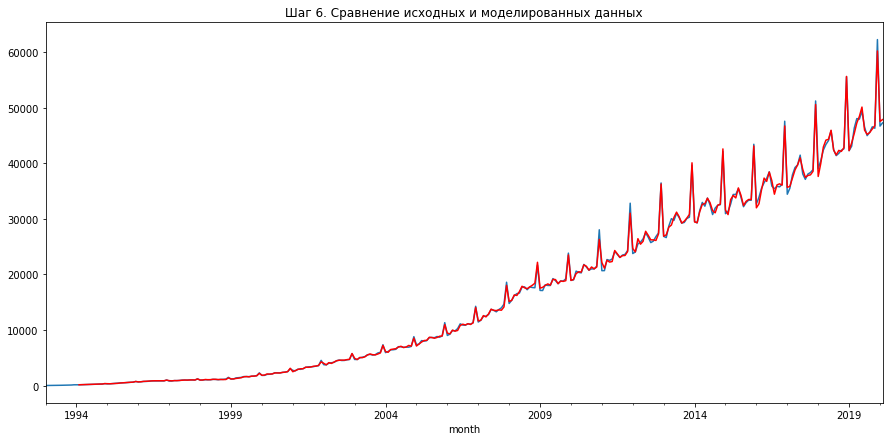

In [12]:
df['model'] = invboxcox(best_model.fittedvalues, _lambda)
plt.figure(figsize(15,7))
df['wage'].plot()
df['model'][13:].plot(kind='line', color='r')
plt.title('Шаг 6. Сравнение исходных и моделированных данных')
pylab.show()

Как видим, графики совпадают настолько хорошо, что даже впору подумать о переобученнности модели.

### Шаг 7. Прогнозирование данных
Построим прогноз по данным до конца 2024 года (58 месяцев).

In [14]:
len(df['wage'])

326

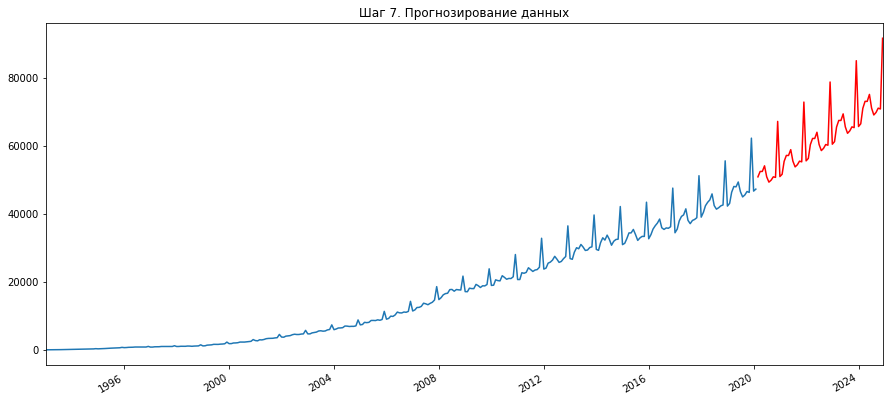

In [17]:
df2 = df[['wage']]
date_list = [datetime.datetime.strptime("2020-02-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,59)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=326, end=384), _lambda)

plt.figure(figsize(15,7))
df2['wage'].plot()
df2['forecast'].plot(color='r')
plt.title('Шаг 7. Прогнозирование данных')
pylab.show()

Ну что же, удовлетворимся предсказанным нам светлым будущим! Следует заметить, что и исходные данные сильно сглажены, на них не заметно следов кризисов 90-х годов, кризиса 2008 и 2014-2016 гг. Быть может, и текущий кризис-2020 по крайней мере в рублевом выражении не оставит их на графике. Спасибо!